In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [5]:
x = df.drop('target',axis=1)
y = df['target']

In [6]:
dataset = pd.get_dummies(df, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size = 0.3, random_state = 42)

In [8]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X=x_train)
scl.scale_

array([ 9.17239753,  0.47358115,  1.03467602, 16.98040355, 54.47794485,
        0.33337412,  0.52583233, 22.69823231,  0.46676667,  1.0890916 ,
        0.61226342,  0.94857071,  0.59297162])

In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [12]:
import optuna
from functools import partial
from sklearn import ensemble ,model_selection
from sklearn import metrics 
from sklearn.metrics import recall_score , precision_score , log_loss , accuracy_score

In [13]:
def optimize(trial, x,y):
    
    criterion      = trial.suggest_categorical("criterion", ["gini","entropy"])
    n_estimators   = trial.suggest_int("n_estimators", 100,1000)
    max_depth      = trial.suggest_int("max_depth", 1,15)
    max_featuers   = trial.suggest_uniform("max_featuers", 0.01 , 1.0)
    
    classifier = ensemble.RandomForestClassifier(
        n_estimators    = n_estimators,
        max_depth       = max_depth,
        max_features    = max_featuers,
        criterion       = criterion,
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    accuracies = []
    for idx in kf.split(X=x , y=y):
        train_idx , test_idx = idx[0] , idx[1]
        x_train = x.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        x_test = x.iloc[test_idx]
        y_test = y.iloc[test_idx]
        
        classifier.fit(x_train,y_train)
        prediction = classifier.predict(x_test)
        acc = metrics.accuracy_score(y_test, prediction)
        accuracies.append(acc)
    
    return -1.0*np.mean(accuracies)

In [14]:
optimization_function = partial(optimize, x=x , y=y)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function,n_trials = 15)

[I 2023-03-04 11:07:14,874] A new study created in memory with name: no-name-8c368c0b-1662-4508-acd9-2e129afbe1d0
C:\Users\Mostafa.DESKTOP-RG9643T\AppData\Local\Temp\ipykernel_15224\1968877974.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_featuers   = trial.suggest_uniform("max_featuers", 0.01 , 1.0)
[I 2023-03-04 11:07:22,615] Trial 0 finished with value: -0.8181720430107526 and parameters: {'criterion': 'gini', 'n_estimators': 712, 'max_depth': 5, 'max_featuers': 0.8165574276768356}. Best is trial 0 with value: -0.8181720430107526.
C:\Users\Mostafa.DESKTOP-RG9643T\AppData\Local\Temp\ipykernel_15224\1968877974.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sug

Accuarcy in train : 0.8584905660377359
Accuarcy in test : 0.8461538461538461
Precision in train : 0.84
Precision in test : 0.8461538461538461
Recall  in train: 0.9130434782608695
Recall  in test: 0.88
log loss 5.313728201188914
CVaccuracy in train: 82.46753% (8.85173%)
CVaccuracy in test: 82.33333% (12.43700%)


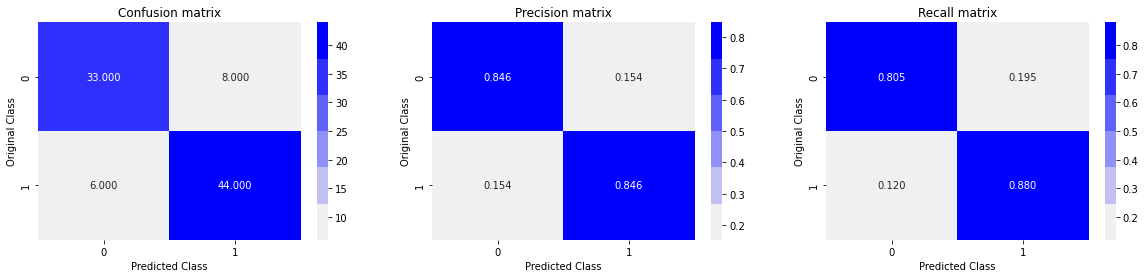

In [15]:
classifier = ensemble.ExtraTreesClassifier(criterion='entropy',n_estimators=521,max_depth=3,max_features= 0.4275736316700092,n_jobs=-1)

classifier.fit(x_train,y_train)
prediction = classifier.predict(x_test)
print('Accuarcy in train :' ,metrics.accuracy_score(y_train,classifier.predict(x_train)))
print('Accuarcy in test :' ,metrics.accuracy_score(y_test,prediction))

print('Precision in train :', precision_score(y_train, classifier.predict(x_train)))
print('Precision in test :', precision_score(y_test, prediction))

print('Recall  in train:', recall_score(y_train, classifier.predict(x_train)))
print('Recall  in test:', recall_score(y_test,prediction))

print('log loss' , metrics.log_loss(y_test, prediction))

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

results = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10,scoring="accuracy")
print("CVaccuracy in train: %.5f%% (%.5f%%)" % (results.mean()*100.0, results.std()*100.0))

results = cross_val_score(estimator = classifier, X = x_test, y = y_test, cv = 10,scoring="accuracy")
print("CVaccuracy in test: %.5f%% (%.5f%%)" % (results.mean()*100.0, results.std()*100.0))

plot_confusion_matrix(y_test,prediction)

Fitting 10 folds for each of 456 candidates, totalling 4560 fits
[CV 1/10; 1/456] START pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100
[CV 1/10; 1/456] END pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100;, score=0.818 total time=   0.1s
[CV 2/10; 1/456] START pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100
[CV 2/10; 1/456] END pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100;, score=0.818 total time=   0.0s
[CV 3/10; 1/456] START pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100
[CV 3/10; 1/456] END pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100;, score=0.810 total time=   0.0s
[CV 4/10; 1/456] START pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100
[CV 4/10; 1/456] END pca__n_components=5, rf__criterion=gini, rf__max_depth=1, rf__n_estimators=100;, score=0.857 total time=   

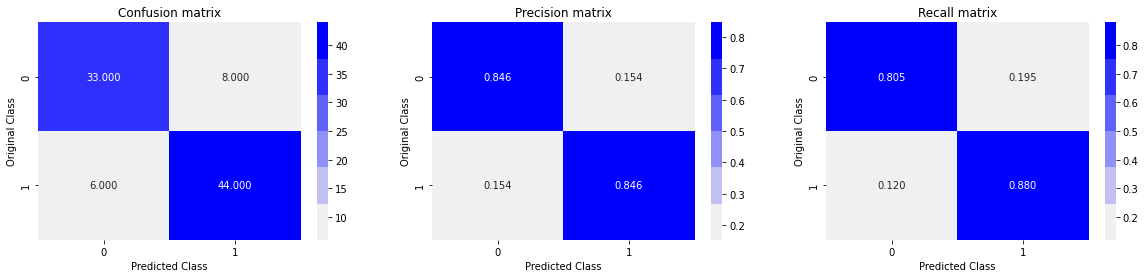

<AxesSubplot:title={'center':'Cross-validated classification metrics'}>

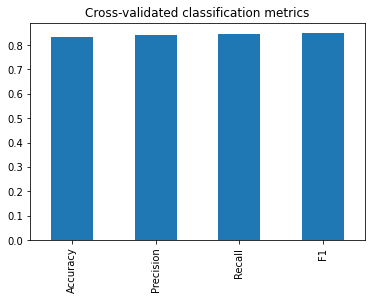

In [16]:
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

scl = preprocessing.StandardScaler()
pca = decomposition.PCA()
rf = RandomForestClassifier(n_jobs = -1)

classifier = pipeline.Pipeline([("scaling", scl),("pca", pca),("rf",rf)])
param_grid = {
    "pca__n_components":np.arange(5,10,2),
    "rf__n_estimators":np.arange(100,500,100),
    "rf__max_depth":np.arange(1,20,),
    "rf__criterion":['gini', 'entropy'],
}

model = model_selection.GridSearchCV(estimator=classifier, param_grid = param_grid,scoring='accuracy',verbose=10,cv=10,n_jobs=1)
model.fit(x_train,y_train)

Accuarcy in train : 0.910377358490566
Accuarcy in test : 0.8461538461538461
Precision in train : 0.8870967741935484
Precision in test : 0.8461538461538461
Recall  in train: 0.9565217391304348
Recall  in test: 0.88
log loss 5.313728201188914


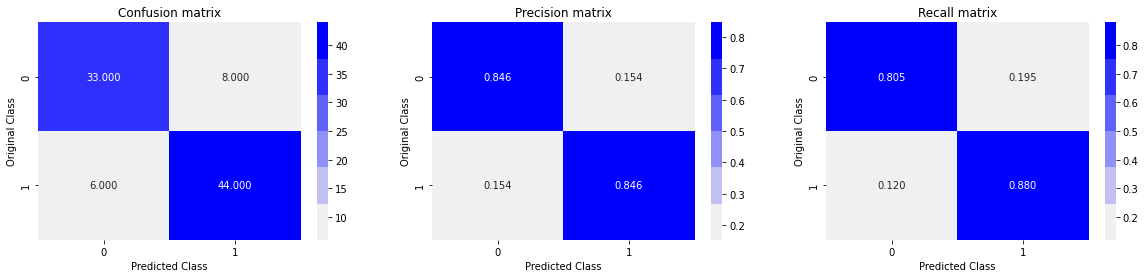

<AxesSubplot:title={'center':'Cross-validated classification metrics'}>

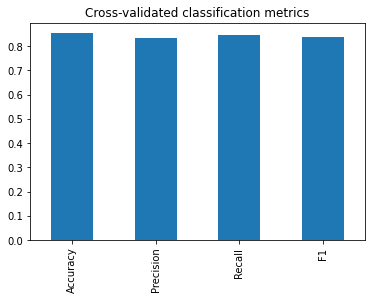

In [18]:

print('Accuarcy in train :' ,metrics.accuracy_score(y_train,model.predict(x_train)))
print('Accuarcy in test :' ,metrics.accuracy_score(y_test,prediction))

print('Precision in train :', precision_score(y_train, model.predict(x_train)))
print('Precision in test :', precision_score(y_test, prediction))

print('Recall  in train:', recall_score(y_train,model.predict(x_train)))
print('Recall  in test:', recall_score(y_test,prediction))

print('log loss' , metrics.log_loss(y_test, prediction))

plot_confusion_matrix(y_test,prediction)

from sklearn.model_selection import cross_val_score
cv_acc = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 5,scoring = "accuracy")
cv_acc = np.mean(cv_acc)
cv_precision = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 5,scoring = "precision")
cv_precision = np.mean(cv_precision)
cv_recall = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 5,scoring = "recall")
cv_recall = np.mean(cv_recall)
cv_f1 = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 5,scoring = "f1")
cv_f1 = np.mean(cv_f1)
cv_metrics = pd.DataFrame({'Accuracy': cv_acc,'Precision': cv_precision,'Recall': cv_recall,'F1': cv_f1},index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",legend=False)


In [24]:
from skopt import gp_minimize
from functools import partial
from skopt  import space
from hyperopt.pyll.base import scope

In [25]:
def optimize(params, x ,y):
    classifier = ensemble.RandomForestClassifier(**params)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X = x, y=y):
        train_idx , test_idx = idx[0] , idx[1]
        x_train = x.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        x_test = x.iloc[test_idx]
        y_test = y.iloc[test_idx]
        
        classifier.fit(x_train, y_train)
        prediction = classifier.predict(x_test)
        acc = metrics.accuracy_score(y_test,prediction)
        accuracies.append(acc)
        
    return -1.0 * np.mean(accuracies)

In [29]:
from hyperopt import hp , fmin, tpe , Trials
from hyperopt.pyll.base import scope
param_space = {
    "max_depth"    : hp.quniform("max_depth", 3, 15 ,1),
    "n_estimators" :scope.int(hp.quniform("n_estimators", 100, 600,1)),
    "criterion"    : hp.choice( "criterion",["gini", "entropy"]),
    "max_features" : hp.uniform("max_featuers",0.01,1)
}
trials = Trials()
optimization_function = partial(optimize, x=x, y=y)
result = fmin(
    fn=optimization_function,
    space=param_space,
    trials=trials,
    algo=tpe.suggest,
    max_evals = 15
)
print(result)

  0%|                                                                           | 0/15 [00:00<?, ?trial/s, best loss=?]

job exception: max_depth must be an instance of int, not float.



  0%|                                                                           | 0/15 [00:00<?, ?trial/s, best loss=?]


TypeError: max_depth must be an instance of int, not float.